In [1]:
import numpy as np
import matplotlib.pyplot as plt
from DatasetGenerator import generate_dataset
import torch
import pickle
np.random.seed(42)

# Generate Example

In [27]:
seed=3
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
np.random.seed(seed)
scene_path = "benchmark_data/N10_M4_ends2_seed3"
print("Running on: " , device)

with open(scene_path, 'rb') as file:
    data = pickle.load(file)
START_locs = data["START_locs"]
F_base = data["F_base"]
END_locs = data["END_locs"]
num_drones = START_locs.shape[0]
num_facilities = F_base.shape[-2]
dim_ = F_base.shape[-1]
num_distinct_ends = len(torch.unique(END_locs, dim=0))
print(f"num_drones = {num_drones}\t num_facilities = {num_facilities}\t dim = {dim_}\t num_distinct_ends = {num_distinct_ends}")
assert(F_base.requires_grad == True)

s = START_locs.cpu().numpy().reshape(-1,1,2)
e = END_locs.cpu().numpy().reshape(-1,1,2)
Y_init = F_base.detach().cpu().numpy()

n_algo_iters = 10
discardPSO = True
discardACO = True

# plot_UAV_FLPO(START_locs, END_locs, F_base, (12,10))
# # plot_UAV_FLPO_3D(START_locs, END_locs, F_base)

Running on:  cpu
num_drones = 10	 num_facilities = 4	 dim = 2	 num_distinct_ends = 2


In [3]:
# create a dataset of nodes and agents
# num_nodes = 10
# num_agents = 30
# dim = 2  # dimension of the space
# def generate_example(dim=2, num_nodes=30, num_agents=20):
#     nodes = 0.5 + 0.01 * np.random.randn(1, num_nodes, dim)  # centered at [0.5, 0.5] with small perturbation
#     s = np.random.rand(num_agents,1, dim)
#     e = np.random.rand(num_agents,1, dim)
#     return s, e, nodes
# s, e, Y_init = generate_example(num_nodes=num_facilities, num_agents=num_drones, dim=dim)

Text(0.5, 1.0, 'Nodes and Agents in 2D Space')

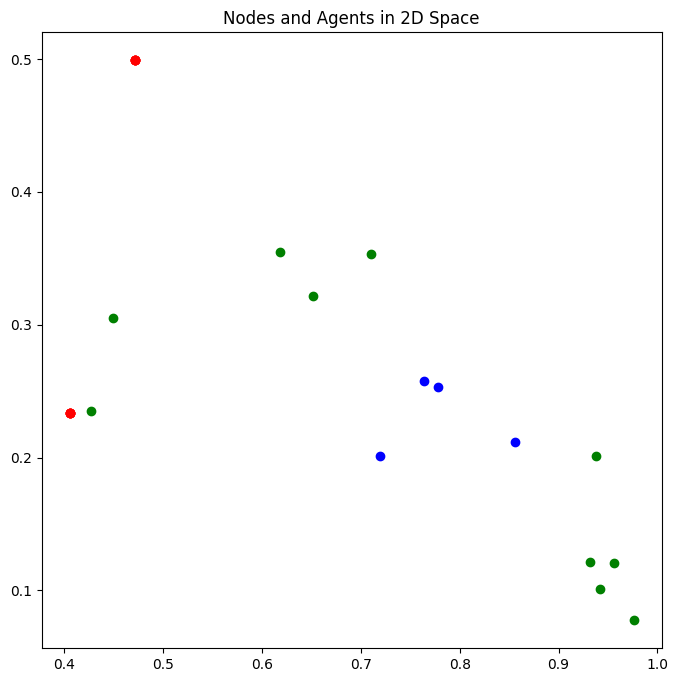

In [28]:

# plot the nodes and agents
plt.figure(figsize=(8, 8))
plt.scatter(Y_init[0, :, 0], Y_init[0, :, 1], c='blue', label='Nodes')
plt.scatter(s[:, 0, 0], s[:, 0, 1], c='green', label='Start Points')
plt.scatter(e[:, 0, 0], e[:, 0, 1], c='red', label='End Points')
plt.title('Nodes and Agents in 2D Space')

# PSO

In [29]:
# run the PSO algorithm
from PSO import pso, pso_plot, pso_print

if discardPSO:
    t_pso_arr = None
    c_pso_arr = None
    t_pso_min = None
    c_pso_min = None
else:
    num_particles = 500
    num_iters = 300
    w = 0.9 # inertia weight
    c1 = 0.5  # cognitive (individual) weight
    c2 =1.5  # social (group) weight
    t_pso_arr = []
    c_pso_arr = []
    for i in range(n_algo_iters):
        y_final, eta_final, global_best_cost, elapsed_time = pso(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            verbose=True,
            w=w,
            c1=c1,
            c2=c2,
            num_particles=num_particles,
            num_iters=num_iters,
        )
        t_pso_arr.append(elapsed_time)
        c_pso_arr.append(global_best_cost)

    t_pso_min = np.min(t_pso_arr)
    c_pso_min = np.min(c_pso_arr)
    pso_print(y_final, eta_final, global_best_cost, elapsed_time, s, e)
    pso_plot(y_final, eta_final, s, e)

In [30]:
t_pso_min, c_pso_min

(None, None)

# Genetic Algorithm

GA Solution:
Best Cost: 0.8330
Elapsed Time: 70.82s
Node positions (y):
  Node 0: [0.59960929 0.28207182]
  Node 1: [0.78217646 0.22743352]
  Node 2: [0.53095834 0.30348078]
  Node 3: [0.59407634 0.27475786]
Agent 0 path:
Node 0  -> Node 2  -> Node 2  -> Node 2  -> End
Agent 1 path:
Node 0  -> Node 0  -> Node 2  -> Node 2  -> End
Agent 2 path:
Node 3  -> Node 0  -> Node 0  -> Node 2  -> End
Agent 3 path:
Node 1  -> Node 0  -> Node 0  -> Node 0  -> End
Agent 4 path:
Node 1  -> Node 0  -> Node 0  -> Node 2  -> End
Agent 5 path:
Node 1  -> Node 1  -> Node 0  -> Node 2  -> End
Agent 6 path:
Node 1  -> Node 0  -> Node 3  -> Node 2  -> End
Agent 7 path:
Node 1  -> Node 0  -> Node 0  -> Node 2  -> End
Agent 8 path:
Node 2  -> Node 0  -> Node 3  -> Node 2  -> End
Agent 9 path:
Node 0  -> Node 0  -> Node 0  -> Node 2  -> End


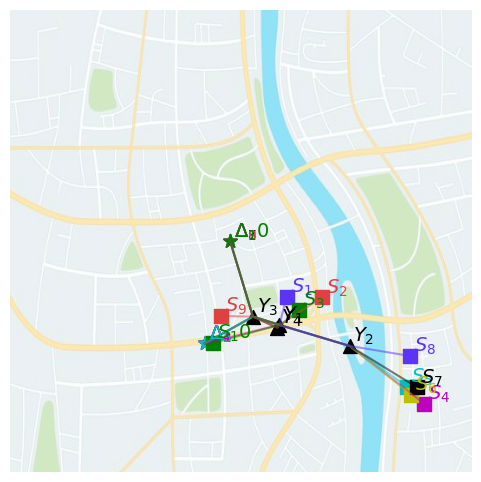

In [7]:
from GA import ga, ga_plot, ga_print
t_ga_arr = []
c_ga_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = ga(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=None,
            verbose=False,
            pop_size=100,
            generations=8000,
            mutation_rate=0.3,        
        )
    t_ga_arr.append(elapsed_time)
    c_ga_arr.append(best_cost)
t_ga_min = np.min(t_ga_arr)
c_ga_min = np.min(c_ga_arr)
ga_print(s, e, best_y, best_eta, best_cost, elapsed_time)
ga_plot(s, e, best_y, best_eta)

In [8]:
t_ga_min, c_ga_min

(70.6879551410675, 0.779460451489532)

# SA

Final solution:
Node positions (y):
  Node 0: [0.57071444 0.34726119]
  Node 1: [0.5917083  0.28279392]
  Node 2: [0.63032193 0.27464374]
  Node 3: [0.59547156 0.24513952]
Agent paths (eta):
  Agent 0: Node 2 -> Node 2 -> Node 2 -> Node 2 -> End
  Agent 1: Node 2 -> Node 2 -> Node 2 -> Node 1 -> End
  Agent 2: Node 1 -> Node 3 -> Node 3 -> Node 1 -> End
  Agent 3: Node 2 -> Node 0 -> Node 0 -> Node 1 -> End
  Agent 4: Node 1 -> Node 2 -> Node 1 -> Node 3 -> End
  Agent 5: Node 3 -> Node 1 -> Node 1 -> Node 3 -> End
  Agent 6: Node 2 -> Node 0 -> Node 0 -> Node 2 -> End
  Agent 7: Node 2 -> Node 2 -> Node 1 -> Node 0 -> End
  Agent 8: Node 2 -> Node 3 -> Node 2 -> Node 1 -> End
  Agent 9: Node 0 -> Node 0 -> Node 1 -> Node 2 -> End
Start positions (s):
  Agent 0: [0.6186674  0.35476613]
  Agent 1: [0.7104527 0.3535505]
  Agent 2: [0.6516481 0.3217567]
  Agent 3: [0.9758923  0.07744691]
  Agent 4: [0.9319452  0.12129531]
  Agent 5: [0.94245046 0.10063247]
  Agent 6: [0.9565085  0.1204334

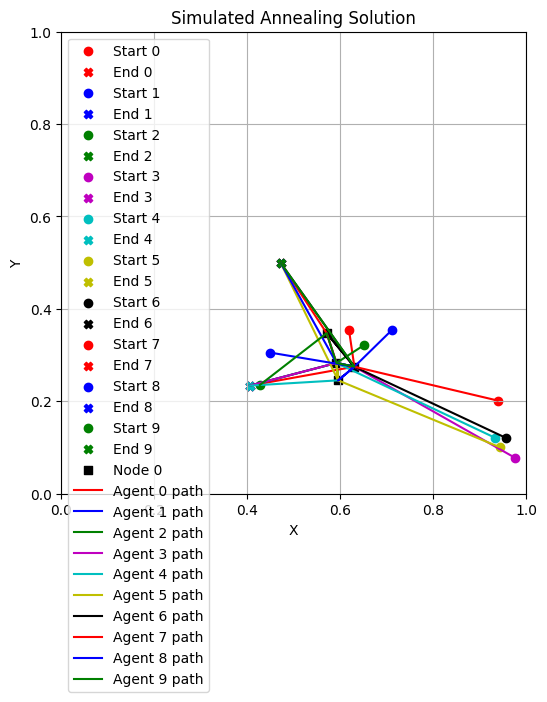

In [12]:
from SA import sa, plot_sa, print_sa
t_sa_arr = []
c_sa_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = sa(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0,
            YMAX=1.0,
            iters=20000,
            verbose=False,
        )
    t_sa_arr.append(elapsed_time)
    c_sa_arr.append(best_cost)
t_sa_min = np.min(t_sa_arr)
c_sa_min = np.min(c_sa_arr)
print_sa(s, e, best_y, best_eta)
plot_sa(s, e, best_y, best_eta)

In [13]:
t_sa_min, c_sa_min

(6.532859802246094, 1.1324071643241533)

# CEM

CEM Solution:
Best Cost: 1.0327
Elapsed Time: 22.50 seconds
Node positions (y):
[[0.5326154  0.35262197]
 [0.55672915 0.31249967]
 [0.71439934 0.25274201]
 [0.63650459 0.27469037]]
Agent paths (indices):
Agent 0: Node 2 -> Node 3 -> Node 0 -> End -> End
Agent 1: Node 3 -> Node 3 -> Node 2 -> Node 0 -> End
Agent 2: Node 3 -> Node 3 -> Node 1 -> End -> End
Agent 3: Node 3 -> Node 3 -> Node 1 -> Node 0 -> End
Agent 4: Node 2 -> Node 3 -> End -> End -> End
Agent 5: Node 2 -> Node 0 -> End -> End -> End
Agent 6: Node 2 -> Node 3 -> Node 1 -> End -> End
Agent 7: Node 2 -> Node 3 -> Node 1 -> Node 0 -> End
Agent 8: End -> End -> Node 0 -> End -> End
Agent 9: Node 1 -> Node 1 -> Node 1 -> Node 0 -> End


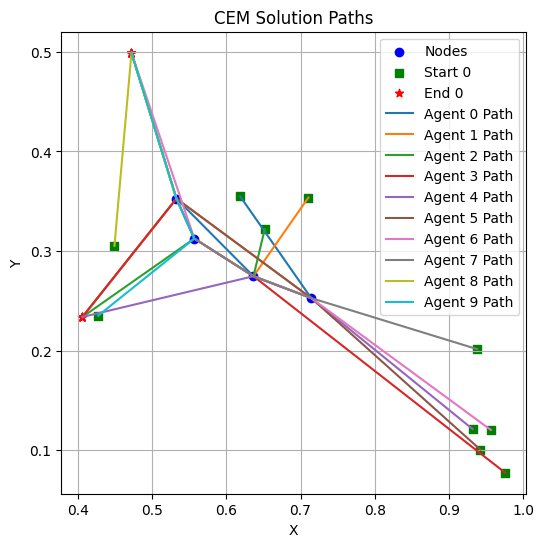

In [31]:
from CEM import cem, plot_cem, print_cem

t_cem_arr = []
c_cem_arr = []
for i in range(n_algo_iters):
    best_y, best_eta, best_cost, elapsed_time = cem(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0,
            YMAX=1.0,
            n_iter=2000,
            pop_size=100,
            elite_frac=0.2,
            verbose=False,
        )
    t_cem_arr.append(elapsed_time)
    c_cem_arr.append(best_cost)
t_cem_min = np.min(t_cem_arr)
c_cem_min = np.min(c_cem_arr)
print_cem(s, e, best_y, best_eta, best_cost, elapsed_time)
plot_cem(s, e, best_y, best_eta)

In [32]:
t_cem_min, c_cem_min

(22.159597158432007, 0.9186522513750327)

# ACO

In [21]:
from ACO import aco, plot_aco, print_aco

if discardACO:
    t_aco_arr = None
    c_aco_arr = None
    t_aco_min = None
    c_aco_min = None
else:
    t_aco_arr = []
    c_aco_arr = []
    for i in range(n_algo_iters):
        best_y, best_eta, best_cost, elapsed_time = aco(
            s,
            e,
            num_facilities,
            num_drones,
            dim_,
            Y_init=Y_init,
            YMIN=0.0,
            YMAX=1.0,
            num_iters=200,
            num_ants=100,
            alpha=1.0,
            beta=1.0,
            rho=0.5,
            Q=1.0,
            verbose=True,
        )
        t_aco_arr.append(elapsed_time)
        c_aco_arr.append(best_cost)
    t_aco_min = np.min(t_aco_arr)
    c_aco_min = np.min(c_aco_arr)
    print_aco(s, e, num_facilities, num_drones, dim_, best_y, best_eta)
    plot_aco(s, e, num_facilities, num_drones, dim_, best_y, best_eta)

In [22]:
t_aco_min, c_aco_min

(None, None)

### Print the benchmark table for all the methods

In [24]:
print(f"---------------------------------------")
print(f"method \t\t cost \t\t time")
print(f"---------------------------------------")
if discardPSO:
    print(f"PSO \t\t NA \t\t NA")
else:
    print(f"PSO \t\t {t_pso_min:.2f} \t\t {c_pso_min:.3f}")
print(f"GA \t\t {c_ga_min:.2f} \t\t {t_ga_min:.1f}")
print(f"SA \t\t {c_sa_min:.2f} \t\t {t_sa_min:.1f}")
print(f"CEM \t\t {c_cem_min:.2f} \t\t {t_cem_min:.1f}")
if discardACO:
    print(f"ACO \t\t NA \t\t NA")
else:
    print(f"ACO \t\t {t_aco_min:.2f} \t\t {c_aco_min:.3f}")
print(f"---------------------------------------")

---------------------------------------
method 		 cost 		 time
---------------------------------------
PSO 		 NA 		 NA
GA 		 0.78 		 70.7
SA 		 1.13 		 6.5
CEM 		 1.01 		 11.0
ACO 		 NA 		 NA
---------------------------------------


# Save benchmark data

In [70]:
import pickle

benchmark_data = {
    "START_locs":START_locs, 
    "F_base":F_base, 
    "END_locs":END_locs,
    "n_algo_iters":n_algo_iters,
    "t_pso_arr":t_pso_arr,
    "c_pso_arr":c_pso_arr,
    "t_ga_arr":t_ga_arr,
    "c_ga_arr":c_ga_arr,
    "t_sa_arr":t_sa_arr,
    "c_sa_arr":c_sa_arr,
    "t_cem_arr":t_cem_arr,
    "c_cem_arr":c_cem_arr,
    "t_aco_arr":t_aco_arr,
    "c_aco_arr":c_aco_arr,    
}

scenario = f"N{int(num_drones)}_M{int(num_facilities)}_ends{int(num_distinct_ends)}_seed{int(seed)}"
filepath = "benchmark_data/" + scenario
print(filepath)

with open(filepath, 'wb') as file:
    pickle.dump(benchmark_data, file)

benchmark_data/N40_M4_ends2_seed3
